In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# LIBRARIES

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time
import scipy

#Separate import for numpy and jax.numpy to have major felxibility
import jax.numpy as jnp
import numpy as np
from jax import jit,lax,random
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates import jax as jtfp
jtfd = jtfp.distributions

np.random.seed(0)

/Users/leopere/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# LOAD DATA

In [159]:
sampled_perturbed = np.load('sampled_2D_two_clusters.npy')

In [160]:
data = sampled_perturbed[0 : 1000]

In [166]:
#DEFINING NUMBER OF CLUSTERS AND DIMENSION OF DATA
k = 5
d = 2
#Key to store for random generation
rng_key = random.PRNGKey(0)

# GIBBS SAMPLER

In [240]:
def run_one_gibbs(data, cluster_allocs, uniq_vals, weights, alpha, lam , key,count,count_tot):
    
    """
    Run one gibbs sampler iteration
    Takes in input values of the previous iteration and sample the new values from sample_uniq_vals_fullcond, update_weights and update_cluster_allocs
    Returns:   
    
    -cluster_allocs: for every data point, the cluster assigned
    -uniq_vals: array of parameters of the distributions. Matrix has d rows of the type:[mu[0], var[0,0], var[0,1]]
    -weights: array with the weights of the clusters 
     """
    
    n_clus = len(weights)
    
    for h in range(n_clus):
        
        #Extract data assigned to cluster h and sample 
        clusdata = data[cluster_allocs == h]
        if len(clusdata) != 0:
            uniq_vals[h, :], acc_rate,count,count_tot = sample_uniq_vals_fullcond_Wasserstein_NW_log(clusdata, lam, uniq_vals, h, key,count,count_tot)
        else:
            print("sono qua")
    weights = update_weights(cluster_allocs ,n_clus, k, alpha)
    
    cluster_allocs = update_cluster_allocs(data, weights, uniq_vals)
    
    return cluster_allocs, uniq_vals, weights, key,count,count_tot




def run_mcmc(data, k,  key , niter=1000, nburn=300, thin=5 ): 
    
    """
    Runs entire MCMC
    Takes in input data, number of clusters, number of iterations, burn-in and thin
    Returns the parameters recorded after burn-in phase
    """
    
    b = time.time() # only to measure time
    count = 0
    count_tot = 0
    
    #Priors
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = np.ones(k)/k
    alpha = 0.1
    lam = 0.1
    uniq_vals = np.dstack([
        tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
        tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
    
    #Output values
    allocs_out = []
    uniq_vals_out = []
    weights_out = []
    
    #Useful value
    data_mean = jnp.mean(data, axis = 0)
    
    #Iterations
    for i in range(niter):
        cluster_allocs, uniq_vals, weights , key,count,count_tot = run_one_gibbs(
            data, cluster_allocs, uniq_vals, weights, alpha, lam , key,count,count_tot)
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            uniq_vals_out.append(uniq_vals.copy())
            weights_out.append(weights)
            
        if i % 10 == 0:
            a = time.time()
            print("\rIter {0} / {1}".format(i+1, niter) + " Remaining minutes: " + str(round((a-b)*(niter-i)/(60*10) ,1)) , flush=False, end=" ")
            b = time.time()
            
    return allocs_out, uniq_vals_out, weights_out,key

# Full Conditionals and Utilities

In [241]:
mu_old = np.array([4,4])
cov_old = np.eye(2)
cov_prop = 0.001*np.eye(2)
nu_prop = 10


mu, cov = sample_from_NW(mu_old, cov_prop, cov_old, nu_prop)
mu_n, lam_n, phi_n, nu_n = compute_param_conjugate_NIW(pos, lam)

print('mu:' + str(mu))
print('cov:' + str(cov))

num_1 = evaluate_NIW(mu, cov, mu_n, lam_n, phi_n, nu_n)
den_1 = evaluate_NIW(mu_old, cov_old , mu_n, lam_n, phi_n, nu_n)

prop_num = evaluate_NW(mu_old , cov_old , mu , cov_prop , cov , nu_prop)
prop_den = evaluate_NW(mu , cov,mu_old , cov_prop , cov_old , nu_prop)

num_1*prop_num/(prop_den*den_1)
# evaluate_NIW(mu_old , cov_old , mu , lambda_prop , cov , nu_prop)

mu:[4.00318208 4.0587929 ]
cov:[[ 0.58846843 -0.12310018]
 [-0.12310018  1.31065454]]


0.0

In [251]:
def sample_uniq_vals_fullcond_Wasserstein_NW_log(clusdata, lam, uniq_vals, h, key,count,count_tot):
    """
    Perform one step of the Metropolis Hastings step to sample a couple (mu,cov) from NIW*Wasserstein
    """

    count_tot = count_tot + 1
    cov_prop = 100*np.eye(2)
    nu_prop = 1000

    #Starting point of MH
    mu_old = np.array([uniq_vals[h,0,0], uniq_vals[h,1,0]])
    cov_old = np.array([[uniq_vals[h,0,1], uniq_vals[h,0,2]], 
                        [uniq_vals[h,1,1], uniq_vals[h,1,2]]])
    

    # Compute the parameters of the updated NIW
    mu_n, lam_n, phi_n, nu_n = compute_param_conjugate_NIW(clusdata, lam)
    
    # Sample the proposal using truncated normal
    mu, cov = sample_from_NW(mu_old, cov_prop, cov_old, nu_prop)

    print("Mu_old: " + str(mu_old))
    print("Mu: " + str(mu))
    print("Cov_old: " + str(cov_old))
    print("Cov: " + str(cov))
    
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_log(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old)
    print("beta")
    print(beta)
    accept_rate = np.minimum(0, beta)
    
    draw = tfd.Uniform().sample()
    

    
    # Select the new or old values without an if to help JAX implementation
    if(np.log(draw) >= accept_rate):
        mu = mu_old
        cov = cov_old
    else:
        count = count + 1
    

    print("Accept Rate:" + str(count/count_tot))
    return np.array([[mu[0], cov[0,0], cov[0,1]],[mu[1], cov[1,0], cov[1,1]]]) , accept_rate,count,count_tot


def compute_beta_NW_log(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old):
    

    cov_prop = 100*np.eye(2)
    nu_prop = 1000
    
    # Target distribution terms
    num_1 = evaluate_NIW_log(mu, cov, mu_n, lam_n, phi_n, nu_n)
    den_1 = evaluate_NIW_log(mu_old, cov_old , mu_n, lam_n, phi_n, nu_n)
    
    prop_num = evaluate_NW_log(mu_old , cov_old , mu , cov_prop , cov , nu_prop)
    prop_den = evaluate_NW_log(mu , cov,mu_old , cov_prop , cov_old , nu_prop)

    # Wasserstein Distances
    sum_ = 0
    for j in range(k):
        if(j != k):
            mu_k = np.array([uniq_vals[j,0,0],uniq_vals[j,1,0]])
            cov_k = np.array( [uniq_vals[j,0,1:3] , uniq_vals[j,1,1:3]]  )
            sum_ = sum_ + compute_Wasserstein(mu , cov , mu_k , cov_k) - compute_Wasserstein(mu_n , np.linalg.inv(phi_n) , mu_k, cov_k)


    
    print("num_1" + str(num_1))
    print("sum" + str(sum_))
    print("den_1" + str(den_1))
    print("prop_num" + str(prop_num))
    print("prop_den" + str(prop_den))
    
    return num_1 + sum_ - den_1 + prop_num - prop_den

In [252]:
def sample_uniq_vals_fullcond_Wasserstein_NW(clusdata, lam, uniq_vals, h, key):
    """
    Perform one step of the Metropolis Hastings step to sample a couple (mu,cov) from NIW*Wasserstein
    """

    cov_prop = 0.001*np.eye(2)
    nu_prop = 4

    #Starting point of MH
    mu_old = np.array([uniq_vals[h,0,0], uniq_vals[h,1,0]])
    cov_old = np.array([[uniq_vals[h,0,1], uniq_vals[h,0,2]], 
                        [uniq_vals[h,1,1], uniq_vals[h,1,2]]])
    

    # Compute the parameters of the updated NIW
    mu_n, lam_n, phi_n, nu_n = compute_param_conjugate_NIW(clusdata, lam)
    
    # Sample the proposal using truncated normal
    mu, cov = sample_from_NW(mu_old, cov_prop, cov_old, nu_prop)

    print("Mu_old: " + str(mu_old))
    print("Mu: " + str(mu))
    print("Cov_old: " + str(cov_old))
    print("Cov: " + str(cov))
    
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old)
    print("beta")
    print(beta)
    accept_rate = np.minimum(1, beta)
    
    draw = tfd.Bernoulli(accept_rate).sample()
    

    
    # Select the new or old values without an if to help JAX implementation
    if(draw == 0):
        mu = mu_old
        cov = cov_old
    

    return np.array([[mu[0], cov[0,0], cov[0,1]],[mu[1], cov[1,0], cov[1,1]]]) , accept_rate




def sample_uniq_vals_fullcond_Wasserstein(clusdata, lam, uniq_vals, h, key):
    """
    Perform one step of the Metropolis Hastings step to sample a couple (mu,cov) from NIW*Wasserstein
    """
#     var_prop = 0.01 #variance for the covariance matrix sampling
#     cov_prop = np.eye(d) #covariance to sample the mean 
    
    nu_prop = 4
    lambda_prop = 1000
    
    #Starting point of MH
    mu_old = np.array([uniq_vals[h,0,0], uniq_vals[h,1,0]])
    cov_old = np.array([[uniq_vals[h,0,1], uniq_vals[h,0,2]], 
                        [uniq_vals[h,1,1], uniq_vals[h,1,2]]])
    

    # Compute the parameters of the updated NIW
    mu_n, lam_n, phi_n, nu_n = compute_param_conjugate_NIW(clusdata, lam)
    
    # Sample the proposal using truncated normal
    #mu,cov = sample_proposal(mu_old,cov_old,var_prop,cov_prop )
    mu, cov = sample_from_NIW(mu_old, lambda_prop, cov_old, nu_prop)

    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_log(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old)
    print("beta")
    print(beta)
    accept_rate = np.minimum(0, beta)
    
    draw = tfd.Uniform().sample()
    

    
    # Select the new or old values without an if to help JAX implementation
    if(np.log(draw) >= accept_rate):
        mu = mu_old
        cov = cov_old
    
    #print(mu)
    #print(cov)
    #print(np.array([[mu[0], cov[0,0], cov[0,1]],[mu[1], cov[1,0], cov[1,1]]]))
    return np.array([[mu[0], cov[0,0], cov[0,1]],[mu[1], cov[1,0], cov[1,1]]]) , accept_rate


def compute_param_conjugate_NIW(clusdata, lam):
    """
    Compute parameters for the conjugate NIW distribution
    """
    n=len(clusdata)
    mean_clus = np.mean(clusdata, axis = 0)
    mean_data = np.mean(data, axis = 0)
    
    W0 = np.diag(np.ones(d))
    C = (n-1)*np.cov(clusdata, rowvar = False)
    D = lam*n/(lam+n)*np.dot(mean_clus - mean_data, mean_clus - mean_data)
    phi_n = (W0 + C + D)
    
    nu_n = d + n
    lam_n = lam + n
    mu_n = (lam * mean_data + n * mean_clus)/(lam+n)
    return mu_n, lam_n, phi_n, nu_n

def sample_from_NIW(mu_n, lam_n, phi_n, nu_n):
    """
    Sample from a NIW given its parameters
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    prec = tfd.WishartTriL(df=nu_n, scale_tril=chol).sample()
    cov = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(mu_n, cov/(lam_n)).sample()
    return mu, cov

def sample_from_NW(mu, cov_prop, sigma, a):
    """
    Sample from a NW given its parameters
    """

    chol = np.linalg.cholesky(sigma/a)
    cov = tfd.WishartTriL(df=a, scale_tril=chol).sample()
  
    mu = tfd.MultivariateNormalFullCovariance(mu, cov_prop).sample()
    return mu, cov

def evaluate_NIW_log(x_mu, x_cov, mu_n, lam_n, phi_n, nu_n):
    """
    Evaluate the likelihood given the parameters of a NIW
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    inv_cov = np.linalg.inv(x_cov)

    f1 = tfd.WishartTriL(df=nu_n, scale_tril=chol).log_prob(inv_cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_n, x_cov/(lam_n)).log_prob(x_mu)
    return f1 + f2

def evaluate_NIW(x_mu, x_cov, mu_n, lam_n, phi_n, nu_n):
    """
    Evaluate the likelihood given the parameters of a NIW
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    inv_cov = np.linalg.inv(x_cov)

    f1 = tfd.WishartTriL(df=nu_n, scale_tril=chol).prob(inv_cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_n, x_cov/(lam_n)).prob(x_mu)
    return f1 * f2

def evaluate_NW(mu , cov, mu_center , cov_param , cov_center , nu_param):
    
    cov_center_chol = np.linalg.cholesky(cov_center/nu_param)
    f1 = tfd.WishartTriL(df=nu_param, scale_tril=cov_center_chol).prob(cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_center, cov_param).prob(mu)
    return f1*f2

def evaluate_NW_log(mu , cov, mu_center , cov_param , cov_center , nu_param):

    cov_center_chol = np.linalg.cholesky(cov_center/nu_param)
    f1 = tfd.WishartTriL(df=nu_param, scale_tril=cov_center_chol).log_prob(cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_center, cov_param).log_prob(mu)
    return f1+f2

def compute_Wasserstein(mu_1, cov_1, mu_2, cov_2):
    """
    Wasserstein distance for the Gaussian Case
    """
    norm = np.linalg.norm(mu_1 - mu_2, ord = 2)
    sqrt_C2 = scipy.linalg.sqrtm(cov_2)
    C1_sqrt_C2 = np.matmul(cov_1,sqrt_C2)
    sqrt_C2_C1_sqrt_C2 = np.matmul(sqrt_C2,C1_sqrt_C2)
    trace = np.trace(cov_1 + cov_2 - 2 * scipy.linalg.sqrtm(sqrt_C2_C1_sqrt_C2))

    return norm + trace

def sample_proposal(mu_old,cov_old,var_prop,cov_prop):
    
    sigma_0 = cov_old[0,0]
    sigma_1 = cov_old[1,1]
    sigma_symm = cov_old[0,1]
    
    mu = tfd.MultivariateNormalFullCovariance(mu_old , cov_prop).sample()
    
    p0 = (sigma_symm ** 2)/sigma_1
    sigma_0_new = tfd.TruncatedNormal(loc = sigma_0, scale = var_prop, low = p0,high = 1e6).sample()
    
    p0_1 = np.sqrt(sigma_0_new * sigma_1)
    sigma_symm_new = tfd.TruncatedNormal(loc = sigma_symm, scale = var_prop, low = -p0_1, high = p0_1).sample()
    
    p1 = (sigma_symm_new ** 2)/sigma_0_new
    sigma_1_new = tfd.TruncatedNormal(loc = sigma_1, scale = var_prop, low = p1,high = 1e6).sample()
    
    cov = np.array([[sigma_0_new , sigma_symm_new],[sigma_symm_new , sigma_1_new]])
    
    return mu,cov
    

def compute_beta(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old):
    """
    Compute the beta term in the MH algorithm
    """
    # Following https://en.wikipedia.org/wiki/Normal-Wishart_distribution notation, 
    # we choose as proposal a NIW with mu_0 the old mean, W the old cov/nu ,
    # lambda and nu to be tuned for the acceptance ratio
    
    # Target distribution terms
    num_1 = evaluate_NIW_log(mu, cov, mu_n, lam_n, phi_n, nu_n)
    den_1 = evaluate_NIW_log(mu_old, cov_old , mu_n, lam_n, phi_n, nu_n)
    
    # Wasserstein Distances
    prod = 1
    for j in range(k):
        if(j != k):
            mu_k = np.array([uniq_vals[j,0,0],uniq_vals[j,1,0]])
            cov_k = np.array( [uniq_vals[j,0,1:3] , uniq_vals[j,1,1:3]]  )
            prod = prod * compute_Wasserstein(mu , cov , mu_k , cov_k) / compute_Wasserstein(mu_n , np.linalg.inv(phi_n) , mu_k, cov_k)


    
    print("num_1" + str(num_1))
    print("prod" + str(prod))
    print("den_1" + str(den_1))
    


    return num_1*prod/den_1

def compute_beta_NW(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old):
    """
    Compute the beta term in the MH algorithm
    """
    cov_prop = 0.001*np.eye(2)
    nu_prop = 1000
    
    # Target distribution terms
    num_1 = evaluate_NIW(mu, cov, mu_n, lam_n, phi_n, nu_n)
    den_1 = evaluate_NIW(mu_old, cov_old , mu_n, lam_n, phi_n, nu_n)
    
    prop_num = evaluate_NW(mu_old , cov_old , mu , cov_prop , cov , nu_prop)
    prop_den = evaluate_NW(mu , cov,mu_old , cov_prop , cov_old , nu_prop)

    # Wasserstein Distances
    prod = 1
    for j in range(k):
        if(j != k):
            mu_k = np.array([uniq_vals[j,0,0],uniq_vals[j,1,0]])
            cov_k = np.array( [uniq_vals[j,0,1:3] , uniq_vals[j,1,1:3]]  )
            prod = prod * compute_Wasserstein(mu , cov , mu_k , cov_k) / compute_Wasserstein(mu_n , np.linalg.inv(phi_n) , mu_k, cov_k)


    
    print("num_1" + str(num_1))
    print("prod" + str(prod))
    print("den_1" + str(den_1))
    print("prop_num" + str(prop_num))
    print("prop_den" + str(prop_den))
    


    return  num_1*prop_num*prod/(prop_den*den_1)


def compute_beta_log(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old):
    """
    Compute the beta term in the MH algorithm
    """
    nu_prop = 4
    lambda_prop = 1000
    
    # Following https://en.wikipedia.org/wiki/Normal-Wishart_distribution notation, 
    # we choose as proposal a NIW with mu_0 the old mean, W the old cov/nu ,
    # lambda and nu to be tuned for the acceptance ratio
    
    # Target distribution terms
    num_1 = evaluate_NIW_log(mu, cov, mu_n, lam_n, phi_n, nu_n)
    den_1 = evaluate_NIW_log(mu_old, cov_old , mu_n, lam_n, phi_n, nu_n)
    
    # Proposal distribution terms
    prop_num = evaluate_NIW_log(mu_old , cov_old , mu , lambda_prop , cov , nu_prop)
    prop_den = evaluate_NIW_log(mu , cov,mu_old , lambda_prop , cov_old , nu_prop)
    
    
    # Wasserstein Distances
    sum_ = 0
    for j in range(k):
        if(j != k):
            mu_k = np.array([uniq_vals[j,0,0],uniq_vals[j,1,0]])
            cov_k = np.array( [uniq_vals[j,0,1:3] , uniq_vals[j,1,1:3]]  )
            sum_ = sum_ + np.log(compute_Wasserstein(mu , cov , mu_k , cov_k)) - np.log(compute_Wasserstein(mu_n , np.linalg.inv(phi_n) , mu_k, cov_k))


    
    print("num_1" + str(num_1))
    print("sum " + str(sum_))
    print("den_1" + str(den_1))
    
    
    return num_1 + sum_ - den_1 + prop_num - prop_den


def update_cluster_allocs(data, weights, uniq_vals):
    #print(weights)
    logprobs = tfd.MultivariateNormalFullCovariance(uniq_vals[:,:,0], uniq_vals[:,:,1:3]).log_prob(data[:, np.newaxis])
    logprobs += np.log(weights)
    probs =  np.exp(logprobs)/(np.sum(np.exp(logprobs), axis=1))[:,None]
    for i in range(len(probs)):
        if np.sum(probs[i]) != 1:
            probs[i] = np.zeros(k)
            idx = np.random.randint(0,k)
            probs[i,idx] = 1
    #print(probs)
    return tfd.Categorical(probs=probs, validate_args=True).sample()


# FUNCTION TO UPDATE THE WEIGHTS 
# IT UPDATES THE PARAMETERS OF THE DIRICHLET AND RETURNS THE NEW WEIGHTS
def update_weights(cluster_allocs, n_clus, k, alpha):

    n_by_clus = np.array([np.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = np.ones(k) * alpha + n_by_clus
    return tfd.Dirichlet(post_params.astype(float)).sample()


def sample_uniq_vals_prior(lam):
    
    chol = tf.linalg.cholesky(np.diag(np.ones(d))) 
    prec = tfd.WishartTriL(df=d, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis = 0), var/lam).sample()
    
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])
    



In [254]:
compute_Wasserstein(np.array([-5,-5]) , np.eye(2) , np.array([5,5]) , np.eye(2))

14.142135623730951

In [253]:
#RUNNING THE MCMC
start = time.time()
allocs_out, uniq_vals_out, weights_out,key = run_mcmc(data, k ,rng_key, niter = 1000,nburn = 500)
end = time.time()
print("Total time: " + str(end-start))



Mu_old: [-1.12364932 -0.82229196]
Mu: [-1.16896876 -0.83158637]
Cov_old: [[ 0.15636355 -0.40856154]
 [-0.40856154  2.96122449]]
Cov: [[ 0.15517255 -0.40518446]
 [-0.40518446  2.94104158]]
num_1-31788.99157317757
sum-11.059763961569224
den_1-31556.884432161987
prop_num2.270324219642468
prop_den2.2903722899555916
beta
-243.18695304746484
Accept Rate:0.0
Mu_old: [ 0.05432    -0.51370921]
Mu: [ 0.04289395 -0.51652339]
Cov_old: [[2.32305534 1.08268956]
 [1.08268956 4.19659841]]
Cov: [[2.15731068 0.89291878]
 [0.89291878 4.11969833]]
num_1-1042.7226939381405
sum-10.635724237188072
den_1-931.544565109502
prop_num-5.063562165160346
prop_den-4.8611792705859616
beta
-122.01623596040099
Accept Rate:0.0
Mu_old: [0.04020521 0.23049064]
Mu: [0.07804124 0.2050978 ]
Cov_old: [[ 0.64511707 -0.76139623]
 [-0.76139623  2.44629042]]
Cov: [[ 0.64890969 -0.79077144]
 [-0.79077144  2.38457124]]
num_1-11549.65886296634
sum-15.409113796859348
den_1-10638.621098160027
prop_num-1.7507167426448929
prop_den-1.5018

num_1-2122.884725046192
sum-5.823225385487115
den_1-2143.4033626852583
prop_num-0.625386636407999
prop_den-0.9599719025014259
beta
15.029997519672406
Accept Rate:0.36
Mu_old: [-1.12364932 -0.82229196]
Mu: [-1.13231096 -0.83223395]
Cov_old: [[ 0.15636355 -0.40856154]
 [-0.40856154  2.96122449]]
Cov: [[ 0.1641106  -0.4256114 ]
 [-0.4256114   2.87852083]]
num_1-522.2108599751641
sum-8.91107996554705
den_1-515.0032750038297
prop_num0.6254348521053767
prop_den0.6771956263093895
beta
-16.1704257110855
Accept Rate:0.34615384615384615
Mu_old: [ 0.06778111 -0.55517823]
Mu: [ 0.04187606 -0.55296219]
Cov_old: [[2.36423908 1.30606382]
 [1.30606382 4.58570923]]
Cov: [[2.43523914 1.38227401]
 [1.38227401 4.55830538]]
num_1-4038.2260582884314
sum-9.393507684031231
den_1-4210.208127860784
prop_num-3.2812994373588866
prop_den-3.2926611438865097
beta
162.59992359484886
Accept Rate:0.37037037037037035
Mu_old: [0.04020521 0.23049064]
Mu: [0.03857318 0.23803601]
Cov_old: [[ 0.64511707 -0.76139623]
 [-0.761

num_1-30246.28692696119
sum-12.636939009601065
den_1-30020.54660897098
prop_num7.209755194350112
prop_den7.260556275546026
beta
-238.42805808100684
Accept Rate:0.3673469387755102
Mu_old: [-0.00619681  0.54645088]
Mu: [0.02817496 0.55298233]
Cov_old: [[ 3.1767911  -3.45790115]
 [-3.45790115  3.89052987]]
Cov: [[ 3.01734719 -3.31444113]
 [-3.31444113  3.76125077]]
num_1-3789.453808904359
sum-7.219325732080758
den_1-3565.28124207234
prop_num-0.7890442256342283
prop_den-0.4665007596728117
beta
-231.7144360300615
Accept Rate:0.36
Mu_old: [-1.14467239 -0.87643447]
Mu: [-1.19930973 -0.84644436]
Cov_old: [[ 0.16813285 -0.44356557]
 [-0.44356557  3.23474128]]
Cov: [[ 0.16900422 -0.45461921]
 [-0.45461921  3.33308107]]
num_1-393.2063388157519
sum-13.994535188896405
den_1-385.8651634966104
prop_num1.82248829781933
prop_den1.777251018693999
beta
-21.29047322891256
Accept Rate:0.35294117647058826
Mu_old: [ 0.00807228 -0.59355909]
Mu: [-0.04227939 -0.5532368 ]
Cov_old: [[2.76174407 1.79022133]
 [1.7

num_1-273.73298192388563
sum-12.888020574155924
den_1-268.6738634599844
prop_num-0.9715253861424955
prop_den-1.0878645299921956
beta
-17.830799894207473
Accept Rate:0.3287671232876712
Mu_old: [-0.35781798  0.21853608]
Mu: [-0.37072239  0.23350507]
Cov_old: [[3.27890053 0.55392038]
 [0.55392038 0.09643716]]
Cov: [[3.29984064 0.55605546]
 [0.55605546 0.09638466]]
num_1-24343.54518761095
sum-6.361635468450171
den_1-22765.251122096695
prop_num6.310559639179969
prop_den6.446192639296255
beta
-1584.791333982821
Accept Rate:0.32432432432432434
Mu_old: [0.00862575 0.54665392]
Mu: [-0.00229396  0.60696645]
Cov_old: [[ 2.9979343  -3.24824546]
 [-3.24824546  3.64776334]]
Cov: [[ 3.02538582 -3.29171712]
 [-3.29171712  3.71753191]]
num_1-1329.7368820811366
sum-4.468283403748301
den_1-1402.9051214308763
prop_num0.8137554587064919
prop_den0.6629427910670351
beta
68.85076861363086
Accept Rate:0.3333333333333333
Mu_old: [-1.14467239 -0.87643447]
Mu: [-1.19755384 -0.84835778]
Cov_old: [[ 0.16813285 -0.4

Exception ignored in: <bound method WeakStructRef._cleanup of WeakStructRef(HashableWeakRef(<weakref at 0x7fb946820830; dead>))>
Traceback (most recent call last):
  File "/Users/leopere/anaconda3/lib/python3.7/site-packages/tensorflow_probability/substrates/numpy/internal/cache_util.py", line 149, in _cleanup
    if self._alive:
AttributeError: _alive


KeyboardInterrupt: 

# Single functions Speed Comparison

In [ ]:
#Data to use for comparison
cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
weights = np.ones(k)/k
alpha = 0.1
lam = 0.1
clusdata = data[cluster_allocs == 2]
uniq_vals = np.dstack([
    tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
    tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
key = rng_key
n_clus = 10

%timeit sample_uniq_vals_fullcond(clusdata,lam,key)
%timeit sample_uniq_vals_fullcond_slow(clusdata,lam)
%timeit update_weights(cluster_allocs, alpha,weights,key)
%timeit update_weights_slow(cluster_allocs, n_clus, k, alpha)
%timeit update_cluster_allocs(data, weights, uniq_vals,key)
%timeit update_cluster_allocs_slow(data, weights, uniq_vals)
%timeit sample_uniq_vals_prior(lam,key)
%timeit sample_uniq_vals_prior_slow(lam)

# PLOT OF THE CLUSTERS

0    298
1    296
3    165
2    131
4    110
dtype: int64


<BarContainer object of 5 artists>

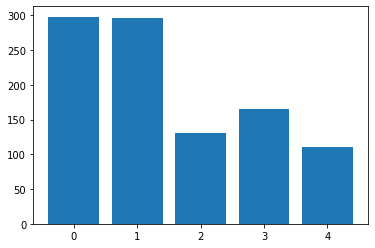

In [230]:
#View the number of points inside each cluster at the final iteration
print(pd.Series(allocs_out[-1]).value_counts())

x, y = np.unique(allocs_out[-1], return_counts=True)


plt.bar(x, y)


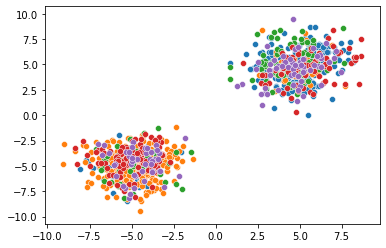

In [231]:
#scatterplot of clusters from last iteration
for h in range(k):
    currd = data[allocs_out[-1] == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

In [233]:
uniq_vals_out[-1]

array([[[ 3.88635869,  3.89542909,  2.83290261],
        [ 3.95337261,  2.83290261,  4.04802463]],

       [[-3.77676854,  6.31181674,  4.70264107],
        [-3.91110419,  4.70264107,  5.74748124]],

       [[ 1.2557535 ,  3.96019886,  4.4656768 ],
        [ 1.98767216,  4.4656768 ,  6.35440092]],

       [[-0.65302592, 20.16622165, 15.48144125],
        [-0.40035158, 15.48144125, 13.69019398]],

       [[ 0.86489199,  6.78191452,  6.40896589],
        [ 1.06523442,  6.40896589,  7.18662127]]])

ValueError: The palette list has the wrong number of colors.

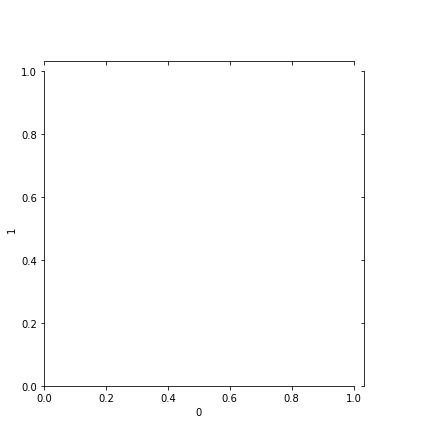

In [120]:
#scatterplot of clusters with marginal distributions
data1=pd.DataFrame(data)
data1["allocs"]=allocs_out[-1]
sns.jointplot(data=data1,x=data1[0],y=data1[1], hue="allocs",palette=sns.color_palette("hls", 4))

In [121]:
#MEDIE NEI CLUSTER DELL'ULTIMA ITERAZIONE
M = [[np.mean(data[allocs_out[-1] == h][:,0]), np.mean(data[allocs_out[-1] == h][:,1])] for h in [5,8,9]]
M=pd.DataFrame(M)


/Users/leopere/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/leopere/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# TRACE PLOTS

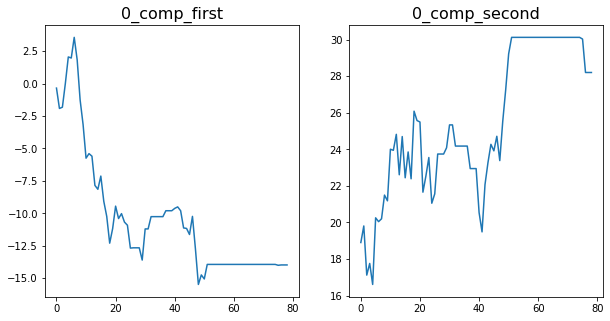

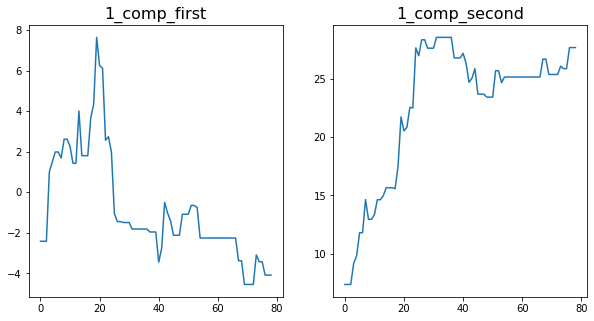

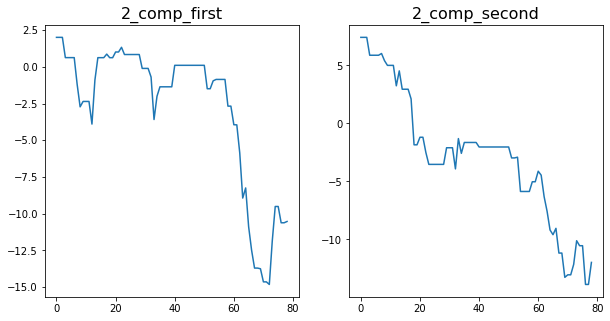

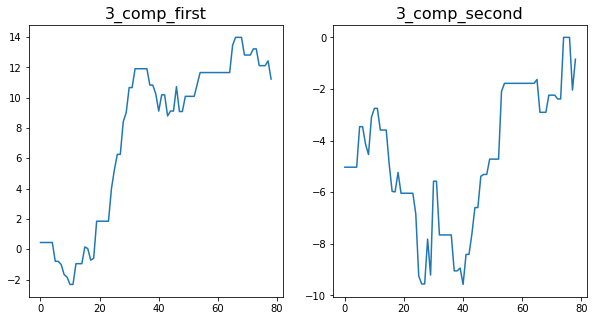

Exception ignored in: <bound method WeakStructRef._cleanup of WeakStructRef(HashableWeakRef(<weakref at 0x7feb0edebca8; dead>))>
Traceback (most recent call last):
  File "/Users/leopere/anaconda3/lib/python3.7/site-packages/tensorflow_probability/substrates/numpy/internal/cache_util.py", line 149, in _cleanup
    if self._alive:
AttributeError: _alive


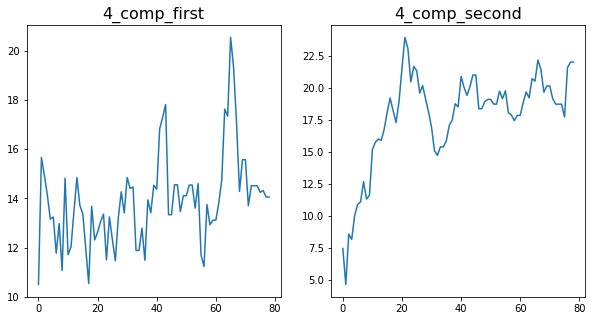

In [122]:
means = [val[:,:,0] for val in uniq_vals_out]
for i in range(len(weights_out[0])):
    

    #Get mean of i-th gaussian component
    first_comp = [mean[i,:] for mean in means]

    #Get mu_1 and mu_2 from the i-th component (multivariate) mean
    first_comp_first = [first_comp_mean[0] for first_comp_mean in first_comp]
    first_comp_second = [first_comp_mean[1] for first_comp_mean in first_comp]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp_first)), first_comp_first)
    axes[0].set_title(str(i) + "_comp_first", fontsize=16)

    axes[1].plot(np.arange(len(first_comp_second)), first_comp_second,)
    axes[1].set_title(str(i) + "_comp_second", fontsize=16)

    plt.show()

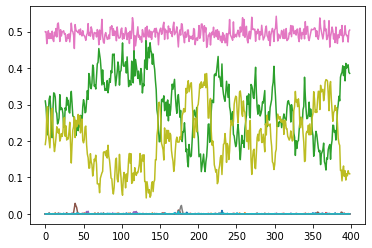

In [17]:
#Weights plot
fig,ax = plt.subplots(1)
for i in range(k):
    ax.plot(np.arange(len(weights_out)), [weight[i] for weight in weights_out])
    
plt.show()

# BEST CLUSTER

In [18]:
#Find best clustering obtained during the MCMC using the Binder Loss 

def get_psm(clus_alloc_chain):
    """
    Returns the posterior similarity matrix, i.e.
        out[i, j] = P(c_i == c_j | all the rest)
    for each pair of observations
    """
    #Fare confronto tra colonna i e j della matrice e poi calcolare da li
    c_chain = np.vstack(clus_alloc_chain)
    out = np.zeros((c_chain.shape[1], c_chain.shape[1]))
    for i in range(c_chain.shape[1]):
        for j in range(c_chain.shape[1]):
            out[i,j] = np.sum(c_chain[:,i] == c_chain[:,j]) / c_chain.shape[0]
            
    return out


def minbinder_sample(clus_alloc_chain, psm):
    """
    Finds the iteration for which the Binder loss is minimized
    and returns the associated clustering
    """
    losses = np.zeros(len(clus_alloc_chain))
    c_chain = np.vstack(clus_alloc_chain)
    
    # You can either cycle through the iterations, or 
    # cycle through the entries in the PSM [i, j]
    # and vectorize the same operation for each iteration!
    
    mat = np.zeros( ( c_chain.shape[0], c_chain.shape[1]**2 ) )
    k = 0
    for i in range(c_chain.shape[1]):
        for j in range(c_chain.shape[1]):
            mat[:,k] = ( (c_chain[:,i] == c_chain[:,j]).astype(int) - psm[i,j] * np.ones(c_chain.shape[0]) ) **2
            k = k+1
    
    losses = np.sum(mat, axis = 1)
    
    best_iter = np.argmin(losses)
    return clus_alloc_chain[best_iter]



def unique_vals_given_clus(unique_vals_chain, clus_alloc_chain, best_clus,n_clus):
    #Finds the unique values associated to the best clusters obtained during MCMC
    
    c_allocs = np.stack(clus_alloc_chain)
    uniq_vals = np.stack(unique_vals_chain)
    means = uniq_vals[:, :, : , 0]
    variances = uniq_vals[:, :, : , 1:3]
    out1 = []
    out2 = []
    for h in range(n_clus):
        data_idx = np.where(best_clus == h)[0]
        uniq_vals_idx = c_allocs[:, data_idx] # -> Matrix [n_iter x n_data_in_clus]
        means_by_iter = np.empty((c_allocs.shape[0], len(data_idx),2))
        vars_by_iter = np.empty((c_allocs.shape[0], len(data_idx),2,2))
        for i in range(c_allocs.shape[0]):
            means_by_iter[i, :] = means[i,uniq_vals_idx[i,:],:]
            vars_by_iter[i, :] = variances[i,uniq_vals_idx[i,:]]

        avg_mean_by_iter = np.mean(means_by_iter , axis = 1)
        avg_var_by_iter = np.mean(vars_by_iter , axis = 1)
        
        muhat = np.mean(avg_mean_by_iter,axis=0)
        sigsqhat = np.mean(avg_var_by_iter,axis=0)
        out1.append(np.array(muhat))
        out2.append(np.array(sigsqhat))
    
    #If there are no points in certain clusters, the output would be full of NANs for the cluster. This gives problems
    #I replace the NANs with some 0
    for i in range(len(out1)):
        if(np.any(np.isnan(out1[i]))):
            out1[i] = np.zeros(shape = out1[i].shape)
        if(np.any(np.isnan(out2[i]))):
            out2[i] = np.eye(N = out2[i].shape[0])
    
        
    return out1,out2


psm = get_psm(allocs_out)
best_clus = minbinder_sample(allocs_out,psm)

mu_lis,var_lis = unique_vals_given_clus(uniq_vals_out, allocs_out, best_clus,k)
weights = np.sum(best_clus == np.arange(k)[:, np.newaxis], axis=1) / len(data)



/Users/Manuel/.virtualenvs/Bayes_Exe/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Manuel/.virtualenvs/Bayes_Exe/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


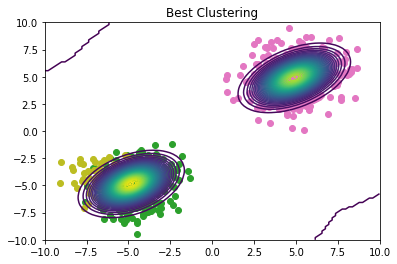

In [19]:
#Plot resulting density of the mixture

def eval_multivariate_mixture_dens(locations, variances, weights, xgrid):
    eval_comps = tfd.MultivariateNormalFullCovariance(locations, np.sqrt(variances)).prob(xgrid[:, np.newaxis])
    return np.sum(eval_comps * weights, axis=1)

grid_1D = np.linspace(-10, 10, 100)
grid_2D = np.array([[x0, y0] for x0 in grid_1D for y0 in grid_1D])
X,Y = np.meshgrid(grid_1D,grid_1D) 
fig = plt.figure()
ax = plt.axes()
ax.contour(X, Y,np.reshape(eval_multivariate_mixture_dens(mu_lis, var_lis, weights, grid_2D), newshape = X.shape) , 50, cmap='viridis')
ax.set_title('Best Clustering');
for h in range(k):
    currd = data[best_clus == h]
    ax.scatter(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd],)